In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Predicting weight of a fish

## 1. Data Visualization and EDA( Exploratory Data Analysis)

In [2]:
df = pd.read_csv('Data/Fish.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [4]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


In [5]:
#Function for correlation matrix
def corr_matrix(dataframe):
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize = (10, 10))  
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(ax=ax,
                mask=mask,
                data=corr, 
                annot=True,
                cmap="YlGnBu",
                robust=True,
               vmin=0,
               vmax=1)
    ax.set_title('Correlation Matrix', fontsize = 16)
    plt.show()

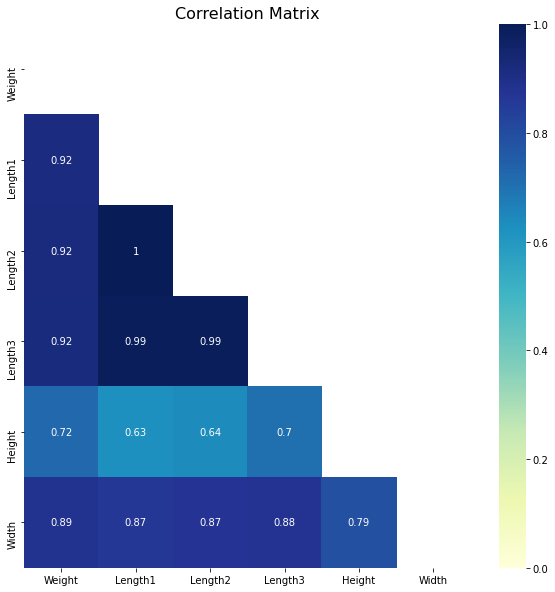

In [6]:
corr_matrix(df)

As it can be seen, in order to predict the fish's weigth, the most important variables are shown in the following list: 
* Length1
* Length2
* Length3
* Width
* Height


Even when Height has the lowest correlation coefficient among the above listed variables, it still has a high correlation with fish's weigth, therefore the variable will be considered for the prediction models, at least for exploring its impact.

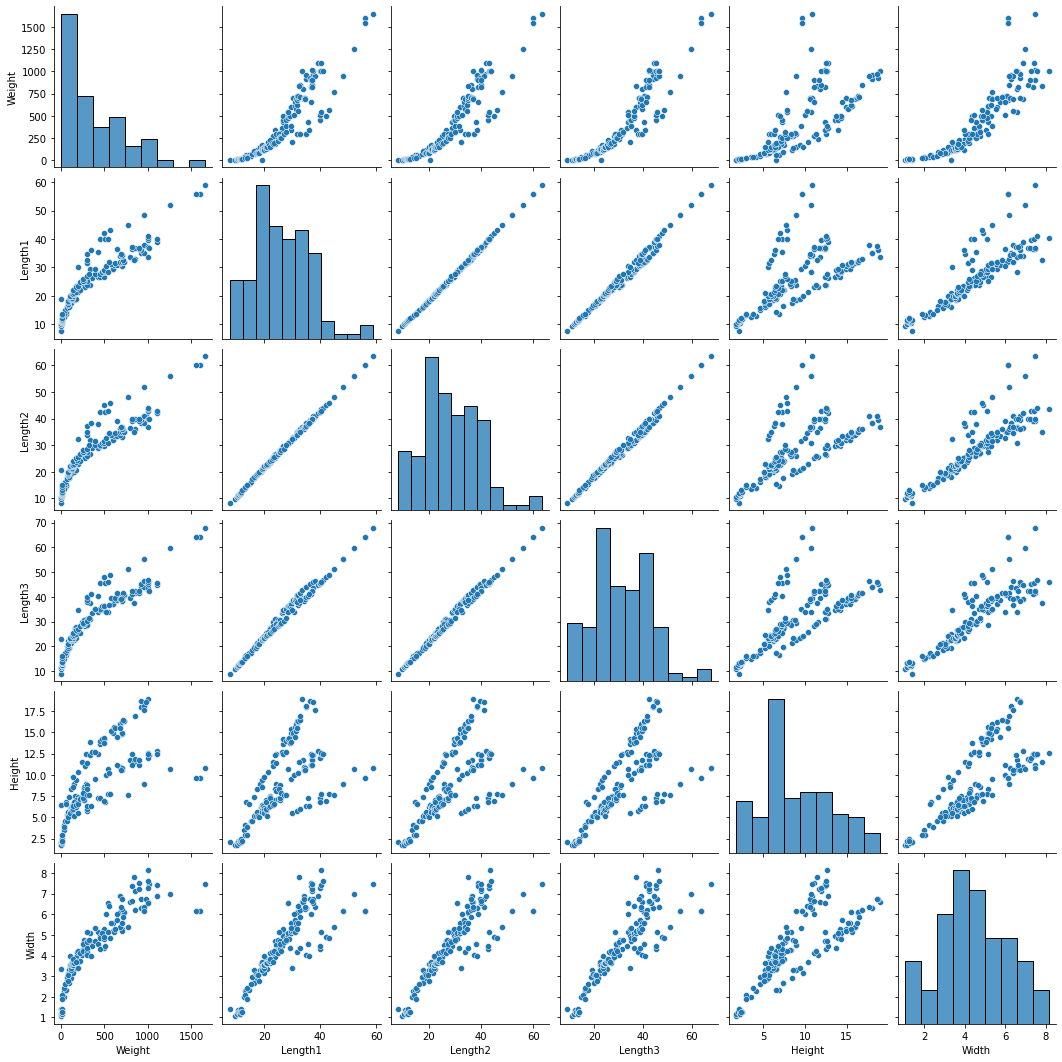

In [7]:
g=sns.pairplot(df)
g.fig.set_size_inches(15,15)


## 2. Managing Data and applying models

In [8]:
#Change the scale to log, be careful with values equal to 0
mean_Weight_Roach = df['Weight'][(df['Species'] =='Roach') & (df['Weight'] != 0)].mean()
df.loc[40,'Weight'] = mean_Weight_Roach
df['log_Width'] = np.log(df['Width'])
df['log_Length1'] = np.log(df['Length1'])
df['log_Length2'] = np.log(df['Length2'])
df['log_Length3'] = np.log(df['Length3'])
df['log_Height'] = np.log(df['Height'])
df['log_Weight'] = np.log(df['Weight'])
df.drop(columns=['Height', 'Weight', 'Width', 'Length1', 'Length2', 'Length3'], axis=1, inplace=True)

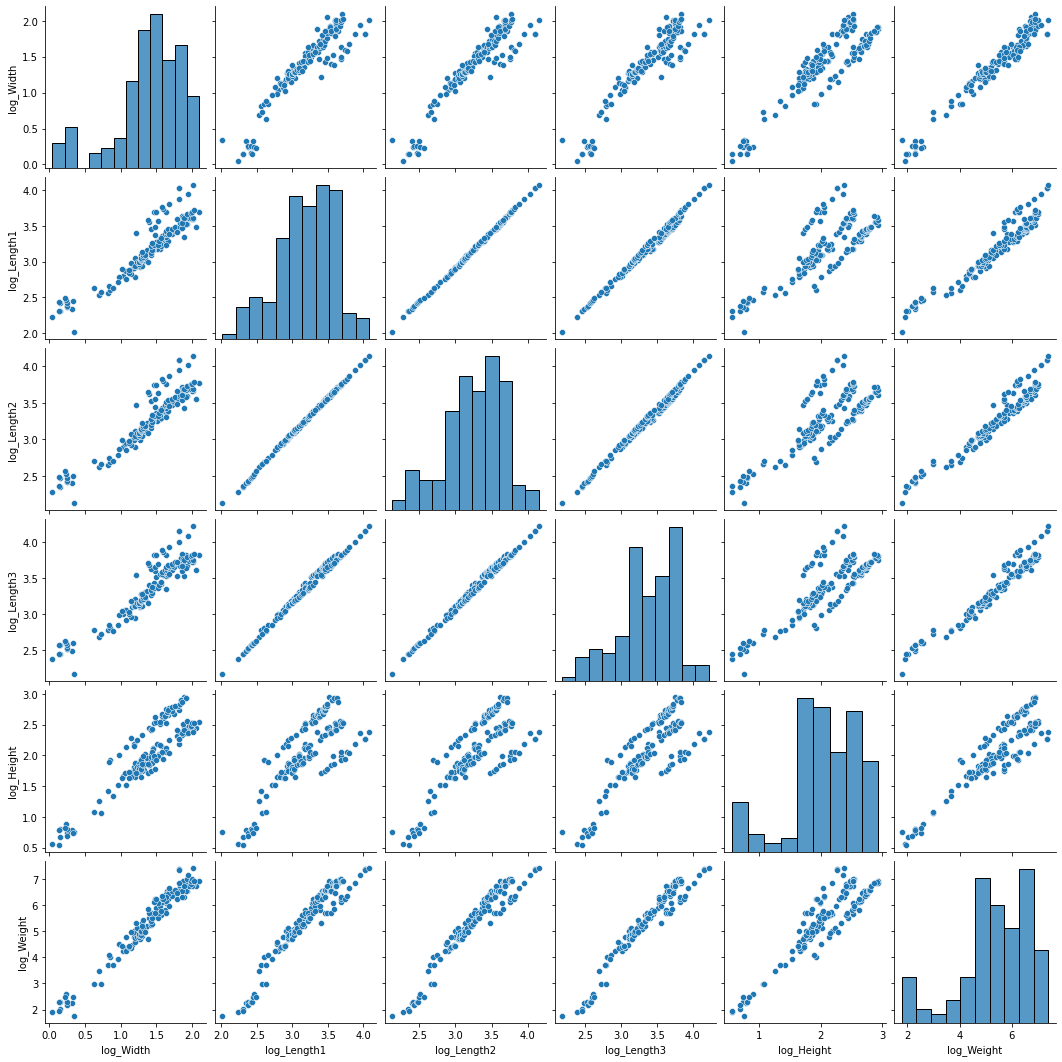

In [9]:
g=sns.pairplot(df)
g.fig.set_size_inches(15,15)

Now that the numerical variables are set in a logarithmical scale, we proceed to use a scaler(Min-Max Scaler).

In [10]:
One_Hot_Species = pd.get_dummies(df.Species)
One_Hot_Species

,Bream,Parkki,Perch,Pike,Roach,Smelt,Whitefish
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
154,0,0,0,0,0,1,0
155,0,0,0,0,0,1,0
156,0,0,0,0,0,1,0
157,0,0,0,0,0,1,0


In [11]:
y = df.pop('log_Weight').values
x = df.values

In [12]:
#One hot encoding of categorical variable(Fish's Specie)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X_dummies = ct.fit_transform(x)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_dummies)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train (127, 12)
X_test (32, 12)
y_train (127,)
y_test (32,)


# Using Linear Regression
For comparing the different models, we will use R2Score and RMSE.


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = np.exp(regressor.predict(X_test))
LinearRegression_r2 = r2_score(np.exp(y_test),y_pred)
LinearRegression_rmse = mean_squared_error(np.exp(y_test), y_pred, squared=False)
LinearRegression_mae = mean_absolute_error(np.exp(y_test), y_pred)
LinearRegression_r2 , LinearRegression_rmse, LinearRegression_mae

(0.9747543201128235, 68.1544090166411, 29.597622264243924)

In [16]:
df_pred = pd.DataFrame()
df_pred['Actual Values'] = np.exp(y_test)
df_pred['Predicted Values'] = y_pred
df_pred['% Diff'] = abs(y_pred-np.exp(y_test))/np.exp(y_test)*100
df_pred['Difference Squared'] = (df_pred['Actual Values'] - df_pred['Predicted Values'])**2
df_pred['Absolute Difference'] = abs(df_pred['Actual Values'] - df_pred['Predicted Values'])
df_pred.sort_values(by=['% Diff'], ascending=False, inplace=True)
df_pred.describe()

,Actual Values,Predicted Values,% Diff,Difference Squared,Absolute Difference
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,443.137500,426.885511,5.808636,4645.023468,29.597622
std,435.807363,408.434033,4.730524,20865.194827,62.374554
min,7.500000,7.655489,0.502131,0.024177,0.155489
25%,104.250000,112.221445,2.064530,14.523308,3.774810
50%,270.000000,265.256973,5.122152,113.462872,10.651774
75%,700.000000,703.586032,8.381646,731.799354,26.864522
max,1650.000000,1684.319418,21.494763,118278.361714,343.916213


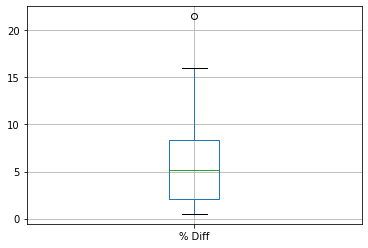

In [17]:
boxplot = df_pred.boxplot(column=['% Diff'])

# Ridge Regression
This linear regression model is used for avoiding multicollinearity.

In [18]:
from sklearn.linear_model import Ridge
ridge_regressor = Ridge(alpha=0.05)
ridge_regressor.fit(X_train, y_train)
y_pred = np.exp(ridge_regressor.predict(X_test))
ridgeRegression_r2 = r2_score(np.exp(y_test),y_pred)
ridgeRegression_rmse = mean_squared_error(np.exp(y_test), y_pred, squared=False)
ridgeRegression_mae = mean_absolute_error(np.exp(y_test), y_pred)
ridgeRegression_r2 , ridgeRegression_rmse, ridgeRegression_mae


(0.9765671558523658, 65.66182098324111, 30.67875914716072)

In [19]:
df_pred_ridge = pd.DataFrame()
df_pred_ridge['Actual Values'] = np.exp(y_test)
df_pred_ridge['Predicted Values'] = y_pred
df_pred_ridge['% Diff'] = abs(y_pred-np.exp(y_test))/np.exp(y_test)*100
df_pred_ridge['Difference Squared'] = (df_pred_ridge['Actual Values'] - df_pred_ridge['Predicted Values'])**2
df_pred_ridge['Absolute Difference'] = abs(df_pred_ridge['Actual Values'] - df_pred_ridge['Predicted Values'])
df_pred_ridge.sort_values(by=['% Diff'], ascending=False, inplace=True)
df_pred_ridge.describe()

,Actual Values,Predicted Values,% Diff,Difference Squared,Absolute Difference
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,443.137500,426.579366,6.248928,4311.474735,30.678759
std,435.807363,410.550620,4.359207,19211.021728,58.983112
min,7.500000,7.518114,0.241524,0.000328,0.018114
25%,104.250000,113.381332,3.329520,22.153701,4.704301
50%,270.000000,262.711533,5.306065,181.859675,13.483149
75%,700.000000,691.415385,8.465194,1001.159123,31.632982
max,1650.000000,1695.682022,20.646179,109123.770053,330.338872


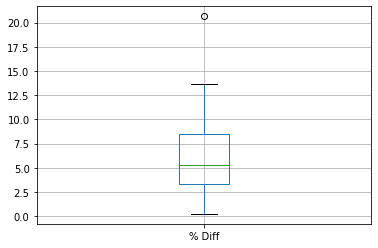

In [20]:
boxplot = df_pred_ridge.boxplot(column=['% Diff'])

# Lasso Regression


In [21]:
from sklearn.linear_model import Lasso
lasso_regressor = Lasso(alpha=0.05)
lasso_regressor.fit(X_train, y_train)
y_pred = np.exp(lasso_regressor.predict(X_test))
lassoRegression_r2 = r2_score(np.exp(y_test),y_pred)
lassoRegression_rmse = mean_squared_error(np.exp(y_test), y_pred, squared=False)
lassoRegression_mae = mean_absolute_error(np.exp(y_test), y_pred)
lassoRegression_r2 , lassoRegression_rmse, lassoRegression_mae


(0.7147182507045347, 229.10650231258225, 118.60935797186545)

In [22]:
df_pred_lasso = pd.DataFrame()
df_pred_lasso['Actual Values'] = np.exp(y_test)
df_pred_lasso['Predicted Values'] = y_pred
df_pred_lasso['% Diff'] = abs(y_pred-np.exp(y_test))/np.exp(y_test)*100
df_pred_lasso['Difference Squared'] = (df_pred_lasso['Actual Values'] - df_pred_lasso['Predicted Values'])**2
df_pred_lasso['Absolute Difference'] = abs(df_pred_lasso['Actual Values'] - df_pred_lasso['Predicted Values'])
df_pred_lasso.sort_values(by=['% Diff'], ascending=False, inplace=True)
df_pred_lasso.describe()

,Actual Values,Predicted Values,% Diff,Difference Squared,Absolute Difference
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,443.137500,339.050906,27.425406,52489.789402,118.609358
std,435.807363,260.852026,22.489077,169462.214260,199.150738
min,7.500000,13.663492,1.218861,3.342649,1.828291
25%,104.250000,133.234425,10.786887,213.556079,14.479098
50%,270.000000,256.662802,23.072547,1105.431583,33.188725
75%,700.000000,570.160811,39.169879,20922.712750,143.900893
max,1650.000000,970.597568,92.117037,866017.241290,930.600474


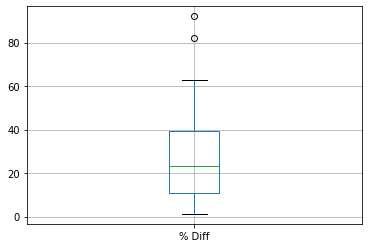

In [23]:
boxplot = df_pred_lasso.boxplot(column=['% Diff'])

In [25]:
ERROR = [['Lasso Linear Regression', lassoRegression_mae,lassoRegression_r2,lassoRegression_rmse],
         ['Ridge Linear Regression', ridgeRegression_mae, ridgeRegression_r2, ridgeRegression_rmse],
         ['Linear Regression', LinearRegression_mae,LinearRegression_r2,LinearRegression_rmse]]

In [26]:
Errors_df = pd.DataFrame(ERROR, columns = ['Method', 'MAE','R2 SCORE','RMSE'])
Errors_df


,Method,MAE,R2 SCORE,RMSE
0,Lasso Linear Regression,118.609358,0.714718,229.106502
1,Ridge Linear Regression,30.678759,0.976567,65.661821
2,Linear Regression,29.597622,0.974754,68.154409


From the last dataframe and the boxplots that show the error's distribution, we can conclude that the Ridge Linear Regression is the model that best fits the data. A simple linear regression also fits very well, but in order to have more solid models, we choose the Ridge Linear Regression model, which includes a regularization technique.